## Sample QC and population definition
#### Yosuke Tanigawa (ytanigaw@stanford.edu)
#### 2019/8/4 (last updated on 2019/8/9)


- We used a combination of PCA (on array genotype data) and self-reported ancestry to define the following five population groups
  - White British (`ukb24983_white_british.phe`, N = 337151)
  - Non-British White (`ukb24983_non_british_white.phe`, N = 24909)
  - African (`ukb24983_african.phe`, N = 6498)
  - South Asian (`ukb24983_s_asian.phe`, N = 7962)
  - East Asian (`ukb24983_e_asian.phe`, N = 1772)
  - In total, we have 378,292 unrelated individuals
- Those files are available: `/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification_w24983_20190805`
- Sample QC criteria
    - Our filtering criteria are as follows:
        - `! in_remove_file`
        - `FID >= 0`
        - `IID >= 0`    
        - `putative_sex_chromosome_aneuploidy == 0`
        - `het_missing_outliers == 0`
        - `excess_relatives == 0`
        - `used_in_pca_calculation == 1`
    - where, 
        - we removed individuals in our "remove file" and individuals with negative FID/IID
        - the remove file is `/oak/stanford/groups/mrivas/ukbb24983/sqc/w24983_20181016.csv`
        - used four fields in sample QC file (sqc file)
- We defined the following thresholds to define ethnic groups
  - White British
      - ` -20 <= PC1 <= 40 && -25 <= PC2 <= 10`
      - `in_white_British_ancestry_subset == 1` (in sample QC file)
  - Non-British White
      - ` -20 <= PC1 <= 40 && -25 <= PC2 <= 10`
      - Based on self-reported ancestry (UKB field 21000), the individual is White, but is not White British.
  - African
      - `260 <= PC1        &&   50 <= PC2`
      - Based on self-reported ancestry (UKB field 21000), the individual is White, but is not any of the followings: White, Asian, Mixed, and Other Ethnic Groups
  - South Asian
      - ` 40 <= PC1 <= 120 && -170 <= PC2 <= -80`
      - Based on self-reported ancestry (UKB field 21000), the individual is White, but is not any of the followings: White, Black, Mixed, and Other Ethnic Groups
  - East Asian
      - `130 <= PC1 <= 170 &&         PC2 <= -230`
      - Based on self-reported ancestry (UKB field 21000), the individual is White, but is not any of the followings: White, Black, Mixed, and Other Ethnic Groups


In [1]:
suppressMessages(require(tidyverse))
suppressMessages(require(data.table))

In [2]:
read_sqc <- function(){
    # This function reads sample QC (sqc) file
    sqc_dir <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/download'
    sqc_cols <- file.path(sqc_dir, 'ukb_sqc_v2.fields.txt') %>% 
    fread(header=F, data.table=F, col.names = 'col') %>% 
    filter(col != '') %>% pull()

    file.path(sqc_dir, 'ukb_sqc_v2.txt') %>% 
    fread(header=F, data.table=F, col.names = sqc_cols)
}

In [3]:
read_fam <- function(fam_file){
    # This function reads PLINK fam file
    fam_file %>% fread(
        header=F, data.table=F, 
        col.names = c('FID', 'IID', 'father', 'mother', 'sex_code', 'batch')
    ) %>%
    left_join(
        data.frame(
            sex_code = c(1, 2, 0),
            sex = c('male', 'female', 'unknown')
        ),
        by='sex_code'
    )    
}

In [4]:
read_remove <- function(){
    # read list of individuals that should be removed from the analysis
    '/oak/stanford/groups/mrivas/ukbb24983/sqc/w24983_20181016.csv' %>%
    fread(header=F, data.table=F, col.names=c('FID')) %>%
    mutate(IID=FID, in_remove_file=TRUE)    
}

In [5]:
read_self_reported_ethnicity <- function(){
    paste0(
        'cat ',
        '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/self_reported_ethnicity/phe/ukb9796_ukb24611_f21000.phe',
        ' | sed -e "s/^#//g"'
    ) %>%
    fread(cmd=., header=T, data.table=F)
}


In [6]:
read_coding1001 <- function(){
    df <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/self_reported_ethnicity/misc/coding1001.tsv' %>%
    fread(header=T, data.table=F, sep='\t')    
    
    df %>%
    mutate(parent_id = if_else(parent_id == 0, coding, parent_id)) %>%
    left_join(
        df %>% select(coding, meaning) %>% rename(
            parent_id = coding, parent_label = meaning
        ),
        by='parent_id'
    ) %>% select(-node_id, -selectable, -parent_id) %>%
    rename(
        coding1001 = coding,
        f21000_top_label = parent_label,
        f21000_sub_label = meaning
    )    
}

In [7]:
read_self_reported_ethnicity_all <- function(){
    '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/self_reported_ethnicity/misc/ukb9796_ukb24611_f21000.tsv' %>%
    fread(header=T, data.table=F) %>%
    rename(
        f21000_0 = '21000.0.0',
        f21000_1 = '21000.1.0',
        f21000_2 = '21000.2.0'    
    )
}


In [8]:
read_master_sqc <- function(){
    fam_df <- read_fam('/oak/stanford/groups/mrivas/ukbb24983/fam/ukb2498_cal_v2_s488370.fam')
    fam_exome_df <- read_fam('/oak/stanford/groups/mrivas/ukbb24983/exome/pgen/spb/data/ukb_exm_spb.fam')
    sqc_df <- read_sqc()
    remove_df <- read_remove()
    self_reported_ethnicity <- read_self_reported_ethnicity()
    coding1001 <- read_coding1001()
    self_reported_ethnicity_all <- read_self_reported_ethnicity_all()
    
    bind_cols(fam_df, sqc_df) %>%
    mutate(fam_order=1:n()) %>%
    left_join(fam_exome_df %>% select(IID) %>% mutate(has_exome = T), by='IID') %>%    
    left_join(remove_df, by=c('FID', 'IID')) %>%
    left_join(self_reported_ethnicity, by=c('FID', 'IID')) %>%
    left_join(coding1001 %>% rename(f21000 = coding1001), by='f21000') %>%
    left_join(self_reported_ethnicity_all, by='IID') %>%
    replace_na(list(in_remove_file=F, has_exome = F)) %>%
    mutate(
        pass_QC_filter = (
            (putative_sex_chromosome_aneuploidy == 0) &
            (het_missing_outliers == 0) & 
            (excess_relatives == 0) & 
            (FID >= 0) &
            (IID >= 0) &
            (! in_remove_file) 
        ),
        pass_filter = (
            pass_QC_filter &
            (used_in_pca_calculation == 1)
        ),        
        self_reported_NBW = if_else(
            (is.na(f21000_0) | (f21000_0 %in% c(1, 1002, 1003))) &
            (is.na(f21000_1) | (f21000_1 %in% c(1, 1002, 1003))) &
            (is.na(f21000_2) | (f21000_2 %in% c(1, 1002, 1003))) &
            (! (is.na(f21000_0) & is.na(f21000_1) & is.na(f21000_2))),            
            T, F
        ),
        self_reported_White = if_else(
            (is.na(f21000_0) | (f21000_0 %in% c(1, 1001, 1002, 1003))) &
            (is.na(f21000_1) | (f21000_1 %in% c(1, 1001, 1002, 1003))) &
            (is.na(f21000_2) | (f21000_2 %in% c(1, 1001, 1002, 1003))) &
            (! (is.na(f21000_0) & is.na(f21000_1) & is.na(f21000_2))),            
            T, F
        ),                
        self_reported_Asian = if_else(
            (is.na(f21000_0) | (f21000_0 %in% c(3, 3001, 3002, 3003, 3004))) &
            (is.na(f21000_1) | (f21000_1 %in% c(3, 3001, 3002, 3003, 3004))) &
            (is.na(f21000_2) | (f21000_2 %in% c(3, 3001, 3002, 3003, 3004))) &
            (! (is.na(f21000_0) & is.na(f21000_1) & is.na(f21000_2))),            
            T, F
        ),                
        self_reported_Black = if_else(
            (is.na(f21000_0) | (f21000_0 %in% c(4, 4001, 4002, 4003))) &
            (is.na(f21000_1) | (f21000_1 %in% c(4, 4001, 4002, 4003))) &
            (is.na(f21000_2) | (f21000_2 %in% c(4, 4001, 4002, 4003))) &
            (! (is.na(f21000_0) & is.na(f21000_1) & is.na(f21000_2))),            
            T, F
        ),                
        self_reported_Mixed_or_Other = if_else(
            (is.na(f21000_0) | (f21000_0 %in% c(6, 2, 2001, 2002, 2003, 2004))) &
            (is.na(f21000_1) | (f21000_1 %in% c(6, 2, 2001, 2002, 2003, 2004))) &
            (is.na(f21000_2) | (f21000_2 %in% c(6, 2, 2001, 2002, 2003, 2004))) &
            (! (is.na(f21000_0) & is.na(f21000_1) & is.na(f21000_2))),            
            T, F            
        )
    ) %>%
    arrange(fam_order)
}

In [9]:
master_sqc_df <- read_master_sqc()

In [10]:
master_sqc_df %>% count(putative_sex_chromosome_aneuploidy) 

putative_sex_chromosome_aneuploidy,n
0,487725
1,652


In [11]:
master_sqc_df %>% count(het_missing_outliers)

het_missing_outliers,n
0,487409
1,968


In [12]:
master_sqc_df %>% count(excess_relatives)

excess_relatives,n
0,488189
1,188


In [13]:
master_sqc_df %>% count(used_in_pca_calculation)

used_in_pca_calculation,n
0,81158
1,407219


In [14]:
count.wo.filter <- master_sqc_df %>% 
count(f21000_top_label, f21000_sub_label, f21000)

count.QC        <- master_sqc_df %>% filter(pass_QC_filter) %>% 
count(f21000_top_label, f21000_sub_label, f21000) %>% rename(n_QC = n)

count.QC.PCA    <- master_sqc_df %>% filter(pass_filter) %>%
count(f21000_top_label, f21000_sub_label, f21000) %>% rename(n_QC_PCA = n)

In [15]:
count.wo.filter %>%
left_join(count.QC %>% select(f21000, n_QC), by='f21000')%>%
left_join(count.QC.PCA %>% select(f21000, n_QC_PCA), by='f21000') %>%
arrange(paste0(f21000))

f21000_top_label,f21000_sub_label,f21000,n,n_QC,n_QC_PCA
Do not know,Do not know,-1,200,200,181
Prefer not to answer,Prefer not to answer,-3,1532,1527,1308
White,White,1,525,522,441
White,British,1001,430764,429219,355099
White,Irish,1002,12579,12518,10495
White,Any other white background,1003,15634,15544,14541
Mixed,Mixed,2,46,46,42
Mixed,White and Black Caribbean,2001,594,593,527
Mixed,White and Black African,2002,397,396,362
Mixed,White and Asian,2003,795,794,719


## We define the thresholds on genotype PCs

In [16]:
pca_plot_lines <- function(p){
    p +
    geom_vline(xintercept=260) +  # African      260 <= PC1        &&   50 <= PC2
    geom_hline(yintercept=50) +  

    geom_vline(xintercept=40) +   # South Asian   40 <= PC1 <= 120 && -170 <= PC2 <= -80
    geom_vline(xintercept=120) +    
    geom_hline(yintercept=-80) +  
    geom_hline(yintercept=-170) +

    geom_vline(xintercept=130) +   # East Asian   130 <= PC1 <= 170 &&         PC2 <= -230
    geom_vline(xintercept=170) +        
    geom_hline(yintercept=-230) + 

    geom_vline(xintercept=-20) +  # European     -20 <= PC1 <=  40 &&  -25 <= PC2 <= 10
    geom_hline(yintercept=-25) +  
    geom_hline(yintercept=10)
}

In [17]:
p <- master_sqc_df %>% filter(pass_filter) %>% drop_na(f21000) %>%
filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC1, y = PC2, color=as.factor(f21000_top_label))) %>%
pca_plot_lines() +
geom_point(alpha=.025) +
theme_bw() + theme(legend.position="bottom") +
guides(colour = guide_legend(override.aes = list(alpha = 1), nrow=2, byrow=TRUE)) +
labs(title='Global PCs', color='Self-reported ethnicity')


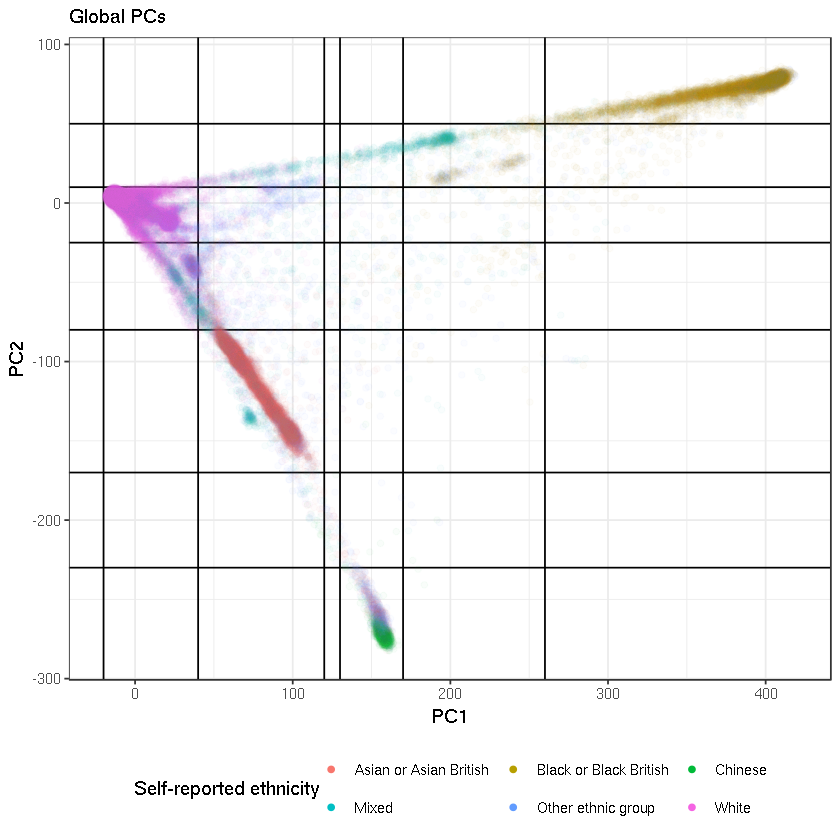

In [18]:
p

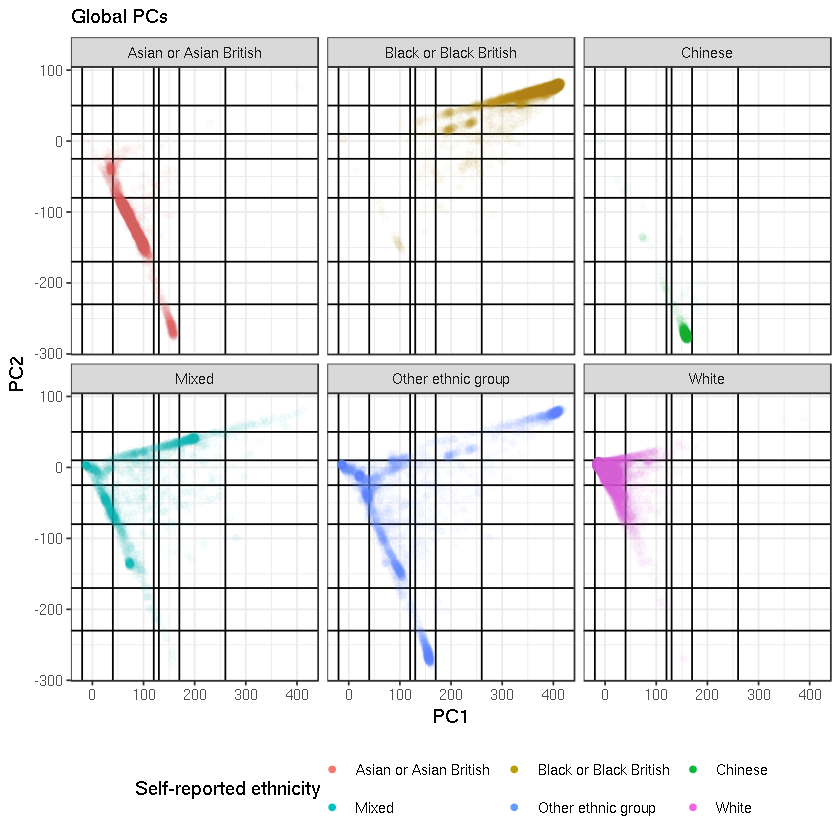

In [19]:
p + facet_wrap( ~ f21000_top_label, ncol=3) 

In [17]:
define_populations <- function(sqc_df){
    pop_df <- sqc_df %>% filter(pass_filter) %>% 
    mutate(
        l_african  = if_else(
            260 <= PC1 &                50 <= PC2 &
            (! self_reported_Asian) & (! self_reported_White) & (! self_reported_Mixed_or_Other), T, F),
        l_s_asian  = if_else(
             40 <= PC1 & PC1 <= 120 & -170 <= PC2 & PC2 <= -80 &
            (! self_reported_Black) & (! self_reported_White) & (! self_reported_Mixed_or_Other), T, F),
        l_e_asian  = if_else(
            130 <= PC1 & PC1 <= 170 &               PC2 <= -230 &
            (! self_reported_Black) & (! self_reported_White) & (! self_reported_Mixed_or_Other), T, F),
        l_European = if_else(
            -20 <= PC1 & PC1 <=  40 &  -25 <= PC2 & PC2 <= 10, T, F),
        l_non_british_white = if_else(l_European & self_reported_NBW, T, F),
        l_white_british  = if_else(l_European & in_white_British_ancestry_subset, T, F)
    ) %>% 
    select(IID, l_white_british, l_non_british_white, l_african, l_s_asian, l_e_asian) %>% 
    gather("population", "label", -IID) %>% filter(label) %>% select(-label) %>%
    mutate(population = str_replace(population, '^l_', ''))
    
    sqc_df %>% left_join(pop_df, by='IID') %>%
    arrange(fam_order)
}


In [18]:
master_sqc_pop_df <- master_sqc_df %>% define_populations()

In [19]:
master_sqc_pop_df %>% colnames()

[1] "FID"                                "IID"                               
 [3] "father"                             "mother"                            
 [5] "sex_code"                           "batch"                             
 [7] "sex"                                "affymetrix_field_1"                
 [9] "affymetrix_field_2"                 "genotyping_array"                  
[11] "Batch"                              "Plate_Name"                        
[13] "Well"                               "Cluster_CR"                        
[15] "dQC"                                "Internal_Pico_ng_uL"               
[17] "Submitted_Gender"                   "Inferred_Gender"                   
[19] "X_intensity"                        "Y_intensity"                       
[21] "Submitted_Plate_Name"               "Submitted_Well"                    
[23] "sample_qc_missing_rate"             "heterozygosity"                    
[25] "heterozygosity_pc_corrected"        "het_missing_outliers"              
[27] "putative_sex_chromosome_aneuploidy" "in_kinship_table"                  
[29] "excluded_from_kinship_inference"    "excess_relatives"                  
[31] "in_white_British_ancestry_subset"   "used_in_pca_calculation"           
[33] "PC1"                                "PC2"                               
[35] "PC3"                                "PC4"                               
[37] "PC5"                                "PC6"                               
[39] "PC7"                                "PC8"                               
[41] "PC9"                                "PC10"                              
[43] "PC11"                               "PC12"                              
[45] "PC13"                               "PC14"                              
[47] "PC15"                               "PC16"                              
[49] "PC17"                               "PC18"                              
[51] "PC19"                               "PC20"                              
[53] "PC21"                               "PC22"                              
[55] "PC23"                               "PC24"                              
[57] "PC25"                               "PC26"                              
[59] "PC27"                               "PC28"                              
[61] "PC29"                               "PC30"                              
[63] "PC31"                               "PC32"                              
[65] "PC33"                               "PC34"                              
[67] "PC35"                               "PC36"                              
[69] "PC37"                               "PC38"                              
[71] "PC39"                               "PC40"                              
[73] "in_Phasing_Input_chr1_22"           "in_Phasing_Input_chrX"             
[75] "in_Phasing_Input_chrXY"             "fam_order"                         
[77] "has_exome"                          "in_remove_file"                    
[79] "f21000"                             "f21000_sub_label"                  
[81] "f21000_top_label"                   "f21000_0"                          
[83] "f21000_1"                           "f21000_2"                          
[85] "pass_QC_filter"                     "pass_filter"                       
[87] "self_reported_NBW"                  "self_reported_White"               
[89] "self_reported_Asian"                "self_reported_Black"               
[91] "self_reported_Mixed_or_Other"       "population"

### count the number of individuals within the five groups

In [20]:
master_sqc_pop_df %>% 
drop_na(population) %>%
count(population, genotyping_array) %>% 
spread(genotyping_array, n, fill= 0) %>%
mutate(n = UKBB + UKBL) %>%
arrange(-n)

population,UKBB,UKBL,n
white_british,300115,37036,337151
non_british_white,22410,2499,24909
s_asian,7962,0,7962
african,6498,0,6498
e_asian,1772,0,1772


In [21]:
master_sqc_pop_df %>% 
drop_na(population) %>%
count(population, has_exome) %>% 
mutate(has_exome = paste0(has_exome)) %>% 
spread(has_exome, n, fill= 0) %>%
rename(w_exome = 'TRUE', wo_exome = 'FALSE') %>%
mutate(n = w_exome + wo_exome) %>%
arrange(-n) %>%
select(population, w_exome, wo_exome, n)

population,w_exome,wo_exome,n
white_british,34395,302756,337151
non_british_white,2694,22215,24909
s_asian,893,7069,7962
african,847,5651,6498
e_asian,187,1585,1772


In [22]:
master_sqc_pop_df %>% 
drop_na(population) %>%
count(population, f21000_top_label) %>% 
spread(f21000_top_label, n, fill= 0)

population,Asian or Asian British,Black or Black British,Chinese,Do not know,Prefer not to answer,White,<NA>
african,0,6306,0,8,120,0,64
e_asian,324,0,1378,5,23,0,42
non_british_white,0,0,0,0,0,24899,10
s_asian,7706,0,11,23,98,0,124
white_british,0,0,0,0,0,337008,143


### Write the initial population definition to phe files
Every time this notebook is run, we should save the new phenotype (`.phe`) files to a new directory that has the date in the name. We have kept the root directory as `/oak/stanford/groups/mrivas/ukbb24983/sqc/` on Sherlock, and the name of the directory as `population_stratification_w24983_YYYYMMDD`.

### It is imperative you rename the directory below, OR ELSE ALL THE PREVIOUS FILES GET OVERWRITTEN. I've commented it out in the GitHub version because of this.


```
out_d <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification_w24983_20190809'
```

In [24]:
pops <- master_sqc_pop_df %>% drop_na(population) %>% select(population) %>% unique() %>% pull()

In [25]:
for (pop in pops){
    print(pop)
    
    master_sqc_pop_df %>% filter(population == pop) %>%
    select(FID, IID) %>% 
    fwrite(file.path(out_d, 'before_refinement', paste0('ukb24983_', pop, '.phe')), sep='\t', col.names = F)    
}

[1] "white_british"
[1] "e_asian"
[1] "non_british_white"
[1] "s_asian"
[1] "african"


In [26]:
master_sqc_pop_df %>%
fwrite(file.path(out_d, 'before_refinement', 'ukb24983_sqc_v2_pop.tsv'), sep='\t', col.names=T)

## Run PCA

- Please check `sample_qc_v3.PCA.sh`


In [27]:
read_eigenvec <- function(dir_name){
    eigenvec <- list()
    for (pop in pops){
        if(pop != 'white_british'){
            eigenvec[[pop]] <- file.path(dir_name, paste0('ukb24983_', pop, '_pca.eigenvec')) %>%
            fread(header=T, data.table=F) %>% rename(FID = '#FID') %>% mutate(population = pop)  
        }
    }
    eigenvec %>% bind_rows()
}

In [28]:
eigenvec_df <- read_eigenvec(file.path(out_d, 'before_refinement', 'pca'))

## Additional clean-up using population specific PCs

In [29]:
apply_threshold <- function(eigenvec_df, x_axis, y_axis, pop, x_lim, y_lim){

    x_min <- x_lim[1]
    x_max <- x_lim[2]
    y_min <- y_lim[1]
    y_max <- y_lim[2]

    p <- eigenvec_df %>% 
    filter(population == pop) %>%
    left_join(master_sqc_pop_df %>% select(IID, f21000, f21000_top_label), by='IID') %>%
    drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
    rename(plot_x = x_axis, plot_y = y_axis) %>%
    ggplot(aes(x = plot_x, y = plot_y, color=as.factor(f21000_top_label))) +
    geom_point(alpha=.025) + 
    theme_bw() + theme(legend.position="bottom") +
    guides(colour = guide_legend(override.aes = list(alpha = 1), nrow=2, byrow=TRUE)) +
    labs(
        x = x_axis, y = y_axis, 
        title='PCs within each population',
        color='Self-reported ethnicity'
    ) + 
    geom_vline(xintercept=x_min) +
    geom_vline(xintercept=x_max) +
    geom_hline(yintercept=y_min) +
    geom_hline(yintercept=y_max)

    eigenvec_df %>% filter(population == pop) %>% dim() %>% print()

    eigenvec_df %>% rename(plot_x = x_axis, plot_y = y_axis) %>%
    filter(
        population == pop,
        x_min <= plot_x, plot_x <= x_max,
        y_min <= plot_y, plot_y <= y_max    
    ) %>% dim() %>% print()   
    
    p
}


#### African -- there's no update

[1] 6498   13
[1] 6498   13


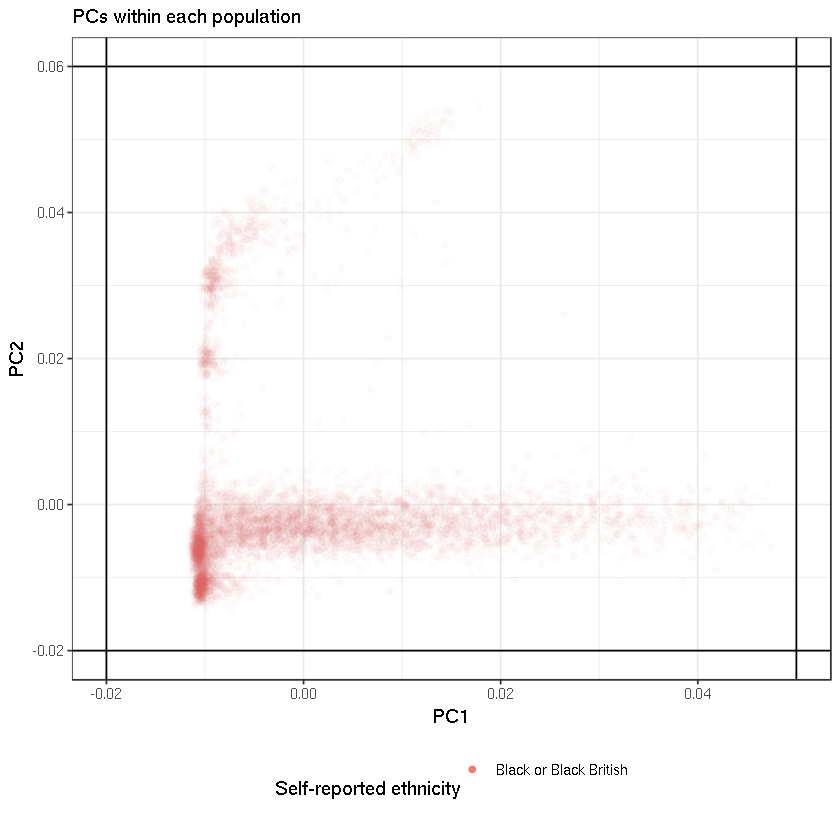

In [34]:
apply_threshold(eigenvec_df, x_axis = 'PC1', y_axis = 'PC2', pop = 'african', c(-0.02, 0.05), c(-0.02, 0.06))


#### Non-British White -- there's no update

[1] 24909    13
[1] 24909    13


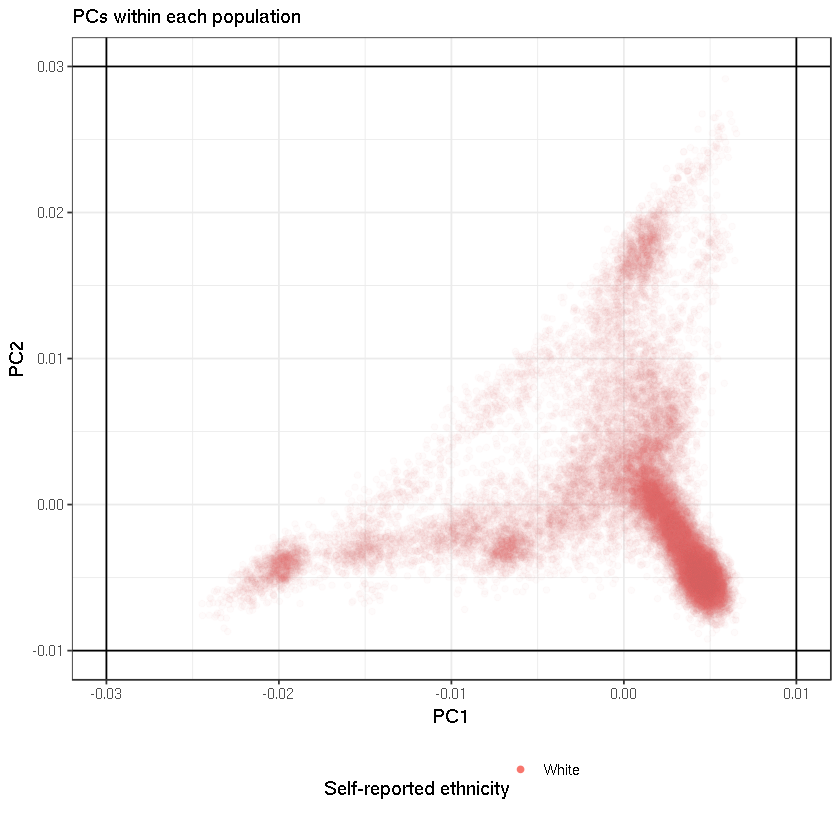

In [35]:
apply_threshold(eigenvec_df, x_axis = 'PC1', y_axis = 'PC2', pop = 'non_british_white', c(-0.03, 0.01), c(-0.01, 0.03))


#### South Asian -- filtering out some individuals

[1] 7962   13
[1] 7885   13


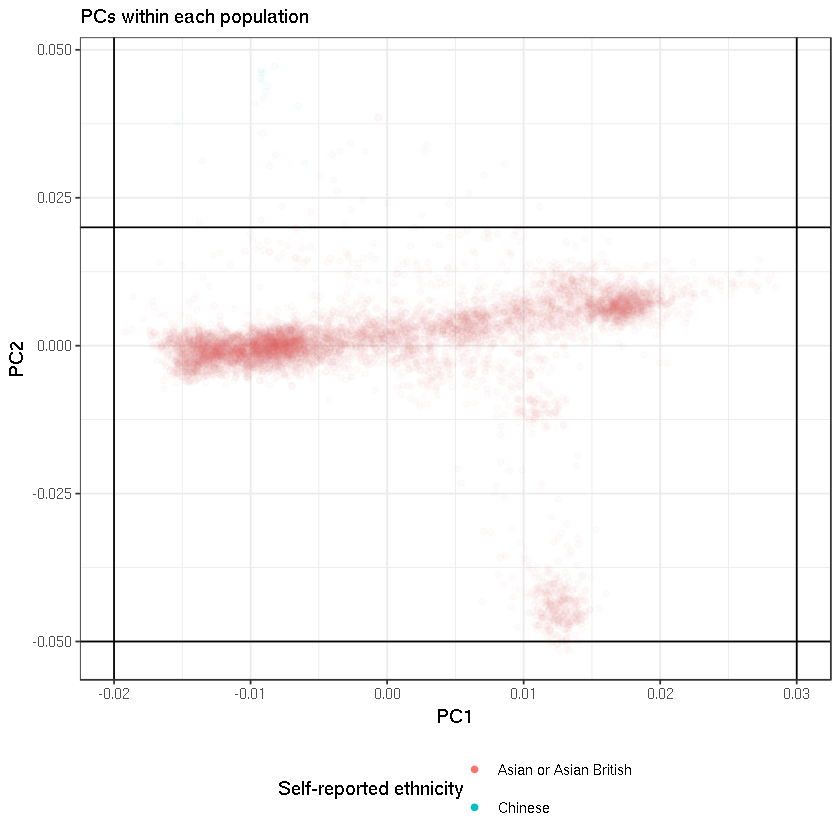

In [36]:
apply_threshold(eigenvec_df, x_axis = 'PC1', y_axis = 'PC2', pop = 's_asian', c(-0.02, 0.03), c(-0.05, 0.02))

#### East Asian -- filtering out some individuals

[1] 1772   13
[1] 1154   13


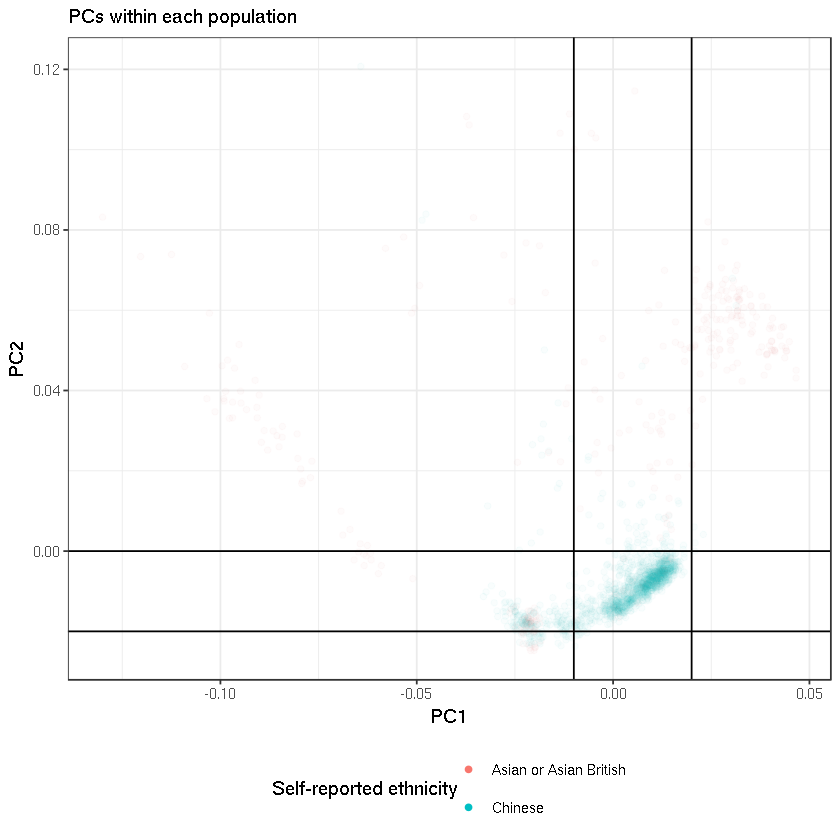

In [37]:
apply_threshold(eigenvec_df, x_axis = 'PC1', y_axis = 'PC2', pop = 'e_asian', c(-0.01, 0.02), c(-0.02, 0))

In [30]:
population_refinement_df <- eigenvec_df %>% mutate(
    population_refined_s_asian = if_else(
        (population == 's_asian') &
        (-0.02 <= PC1) & (PC1 <= 0.03) &
        (-0.05 <= PC2) & (PC2 <= 0.02), T, F
    ),
    population_refined_e_asian = if_else(
        (population == 'e_asian') &
        (-0.01 <= PC1) & (PC1 <= 0.02) &
        (-0.02 <= PC2) & (PC2 <= 0), T, F
    ),    
) %>% select(IID, population_refined_s_asian, population_refined_e_asian)

In [31]:
population_refinement_df %>% count(population_refined_s_asian, population_refined_e_asian)

population_refined_s_asian,population_refined_e_asian,n
FALSE,FALSE,32102
FALSE,TRUE,1154
TRUE,FALSE,7885


In [32]:
master_sqc_pop_ref_df <- master_sqc_pop_df %>% 
mutate(
    population = if_else(population == 's_asian', 's_asian_outlier', population),
    population = if_else(population == 'e_asian', 'e_asian_outlier', population)    
) %>% 
left_join(population_refinement_df, by='IID') %>%
mutate(
    population = if_else(population_refined_s_asian, 's_asian', population),
    population = if_else(population_refined_e_asian, 'e_asian', population),    
) %>%
select(-population_refined_s_asian, -population_refined_e_asian)

In [33]:
for (pop in c('s_asian', 'e_asian')){
    print(pop)
    
    master_sqc_pop_ref_df %>% filter(population == pop) %>%
    select(FID, IID) %>% 
    fwrite(file.path(out_d, paste0('ukb24983_', pop, '.phe')), sep='\t', col.names = F)    
}

[1] "s_asian"
[1] "e_asian"


### for the other populations, we placed symlinks

```
[ytanigaw@sh-ln01 login /oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification_w24983_20190809]$ 
$ ln -s before_refinement/ukb24983_white_british.phe .
$ ln -s before_refinement/ukb24983_non_british_white.phe .
$ ln -s before_refinement/ukb24983_african.phe .
```

### Prepare GWAS covariate file

In [34]:
eigenvec_refined_df <- read_eigenvec(file.path(out_d, 'pca'))

In [35]:
eigenvec_refined_df %>% colnames()

[1] "FID"        "IID"        "PC1"        "PC2"        "PC3"       
 [6] "PC4"        "PC5"        "PC6"        "PC7"        "PC8"       
[11] "PC9"        "PC10"       "PC11"       "PC12"       "PC13"      
[16] "PC14"       "PC15"       "PC16"       "PC17"       "PC18"      
[21] "PC19"       "PC20"       "PC21"       "PC22"       "PC23"      
[26] "PC24"       "PC25"       "PC26"       "PC27"       "PC28"      
[31] "PC29"       "PC30"       "PC31"       "PC32"       "PC33"      
[36] "PC34"       "PC35"       "PC36"       "PC37"       "PC38"      
[41] "PC39"       "PC40"       "population"

In [43]:
# eigenvec_refined_df <- master_sqc_pop_ref_df %>% 
# filter(population %in% c('non_british_white', 'e_asian', 's_asian', 'african')) %>%
# select(IID) %>% 
# left_join(
#     read_eigenvec(file.path(out_d, 'before_refinement', 'pca')), 
#     by='IID'
# )

In [36]:
read_gwas_covar <- function(){
    fread(cmd=paste0(
        'cat ', 
        '/oak/stanford/groups/mrivas/ukbb24983/sqc/ukb24983_GWAS_covar.pre.20190805.phe', 
        ' | sed -e "s/PC/Global_PC/g"'
    ), sep='\t', header=T, data.table=F)
}

In [38]:
gwas_covar_global_df <- read_gwas_covar()

In [68]:
covar_bmi_f <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/9796/24611/phe/INI21001.phe'
covar_age_f <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/time_phenotypes/misc/age_assess.phe'

additional_covar_df <- 
fread(covar_bmi_f, data.table=F, sep='\t', col.names=c('FID', 'IID', 'BMI')) %>%
left_join(fread(covar_age_f, data.table=F, sep='\t'), by='IID')


In [70]:
gwas_covar_df <- master_sqc_pop_df %>% filter(population == 'white_british') %>%
select(FID, IID, paste0('PC', 1:40), population) %>% bind_rows(eigenvec_refined_df) %>%
right_join(gwas_covar_global_df, by=c('FID', 'IID')) %>%
left_join(additional_covar_df, by=c('FID', 'IID')) %>%
select(FID, IID, age, age0, age1, age2, sex, BMI, Array, paste0('PC', 1:40), paste0('Global_PC', 1:40), population) %>%
replace_na(setNames(as.list(rep(0, 40)), paste0('PC', 1:40)))


In [73]:
gwas_covar_df %>% filter(PC1 != 0) %>% dim()

[1] 377597     90

In [71]:
gwas_covar_df %>%  dim()

[1] 488377     90

In [76]:
gwas_covar_df %>% 
replace_na(list(population='NA')) %>%
fwrite(file.path(out_d, 'ukb24983_GWAS_covar.20190809.phe'), sep='\t', na = "NA", quote=F)


### plot PCs within population

In [50]:
plot_eigenvec <- function(evec_df, x_axis, y_axis){
    evec_df %>% 
    left_join(master_sqc_pop_df %>% select(IID, f21000, f21000_top_label), by='IID') %>%
    drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
    rename(plot_x = x_axis, plot_y = y_axis) %>%
    ggplot(aes(x = plot_x, y = plot_y, color=as.factor(f21000_top_label))) +
    geom_point(alpha=.025) + 
    theme_bw() + theme(legend.position="bottom") +
    guides(colour = guide_legend(override.aes = list(alpha = 1), nrow=2, byrow=TRUE)) +
    labs(
        x = x_axis, y = y_axis, 
        title='PCs within each population',
        color='Self-reported ethnicity'
    ) +
    facet_wrap( ~ population, ncol=2)     
}

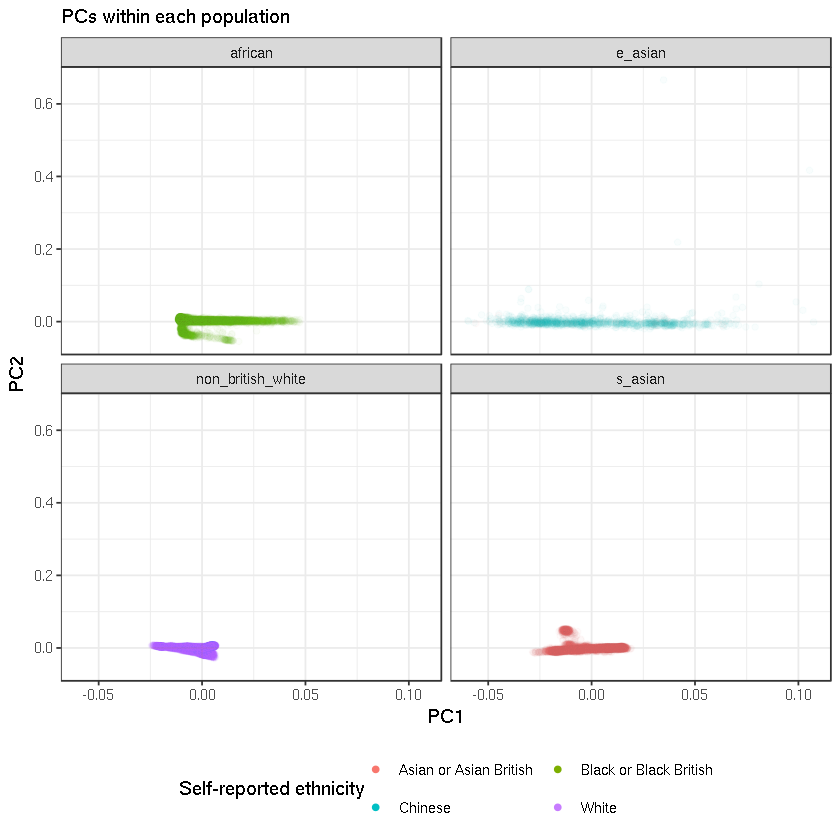

In [51]:
eigenvec_refined_df %>% plot_eigenvec('PC1', 'PC2')


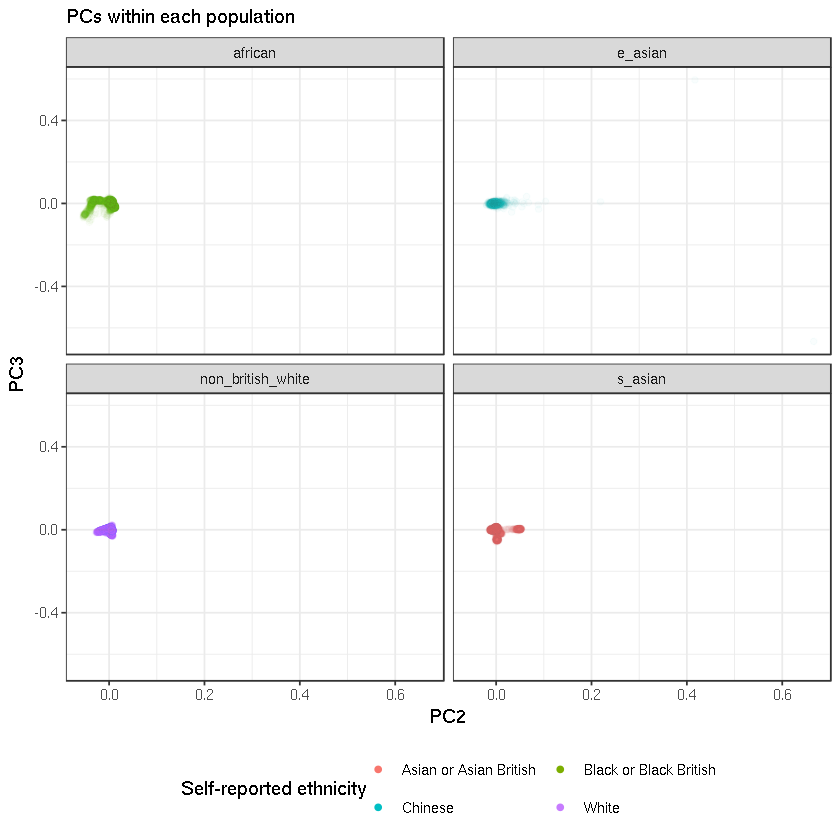

In [52]:
eigenvec_refined_df %>% plot_eigenvec('PC2', 'PC3')


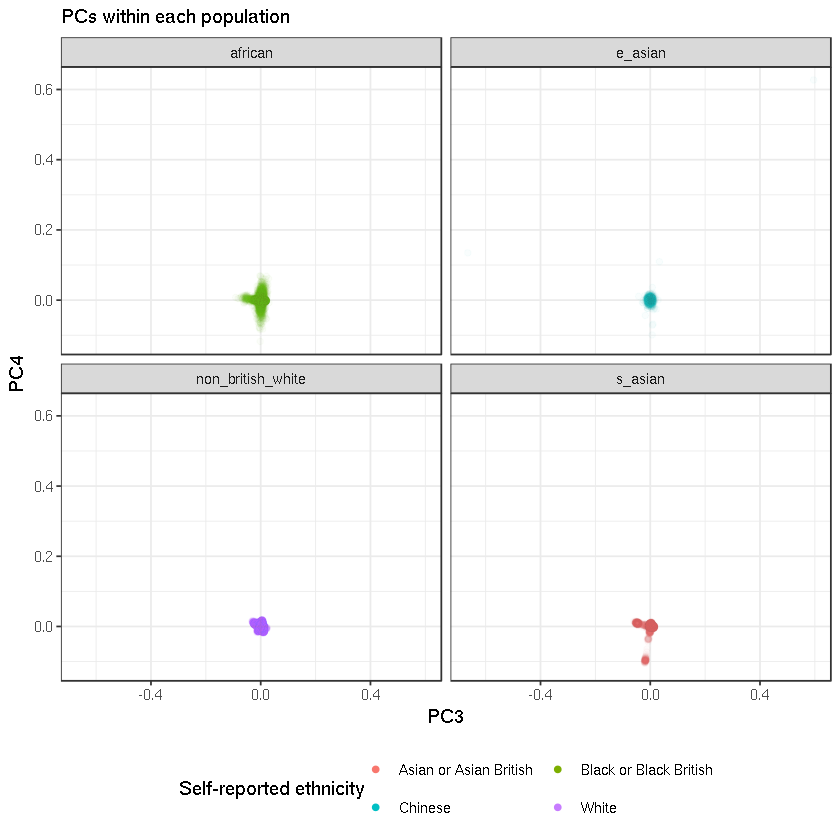

In [53]:
eigenvec_refined_df %>% plot_eigenvec('PC3', 'PC4')


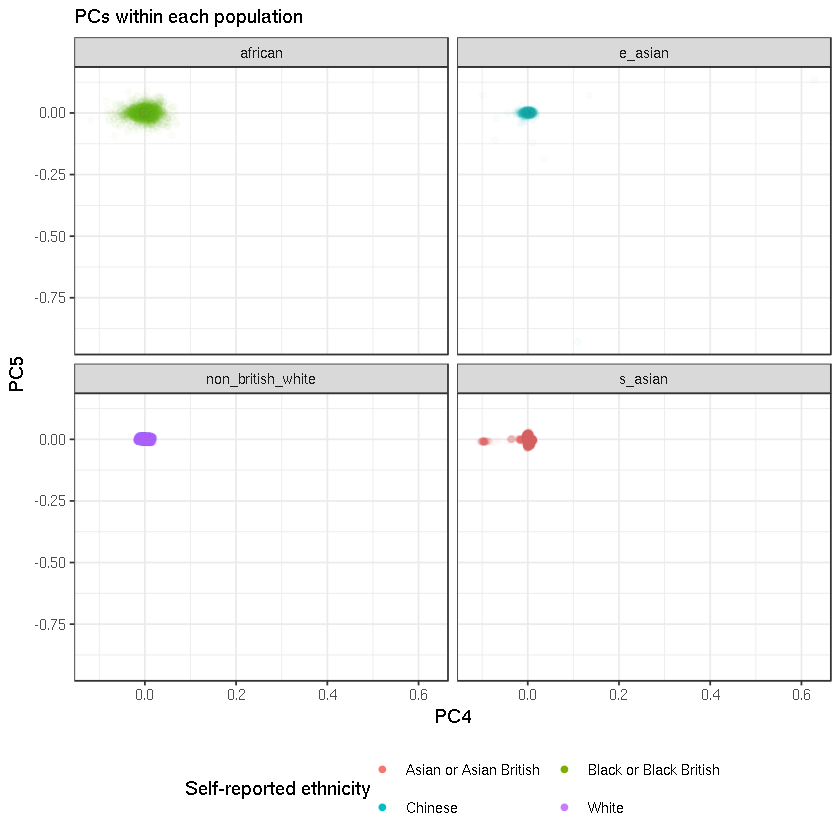

In [54]:
eigenvec_refined_df %>% plot_eigenvec('PC4', 'PC5')


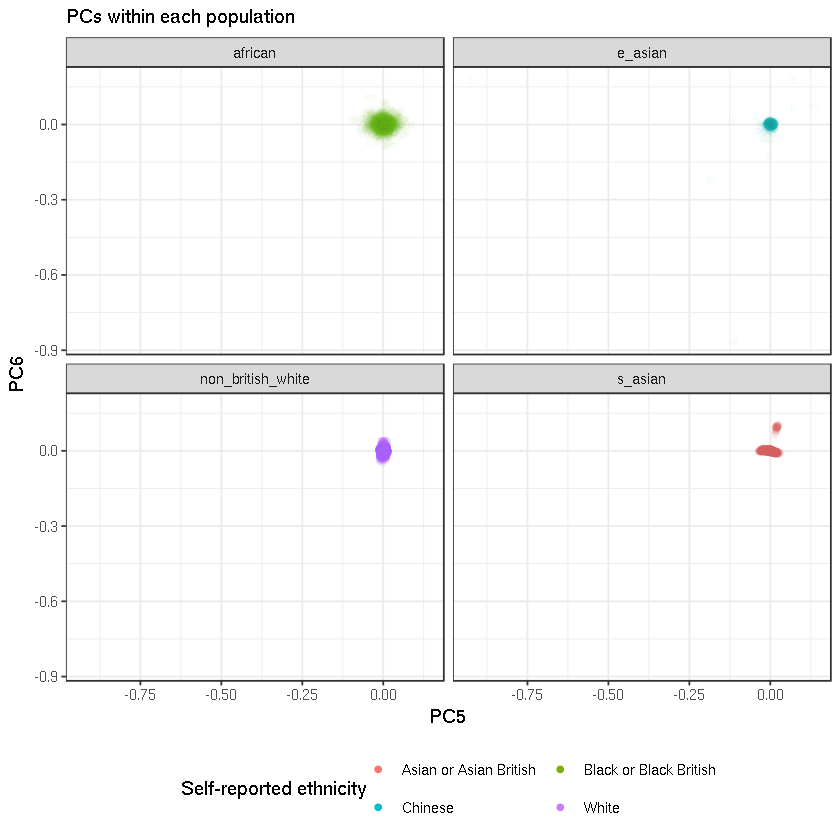

In [55]:
eigenvec_refined_df %>% plot_eigenvec('PC5', 'PC6')


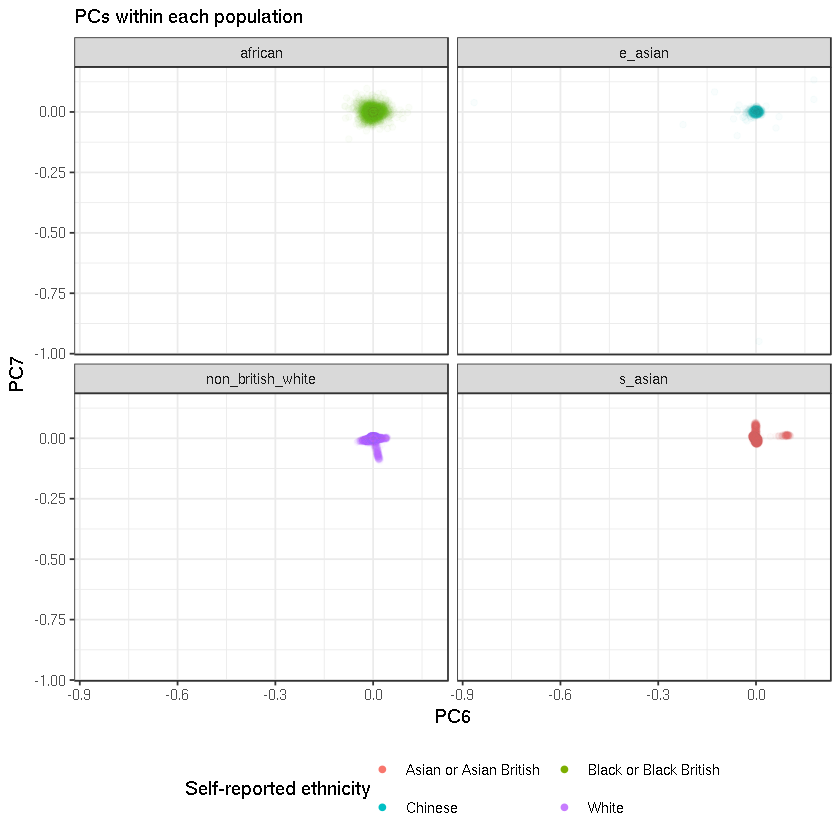

In [56]:
eigenvec_refined_df %>% plot_eigenvec('PC6', 'PC7')


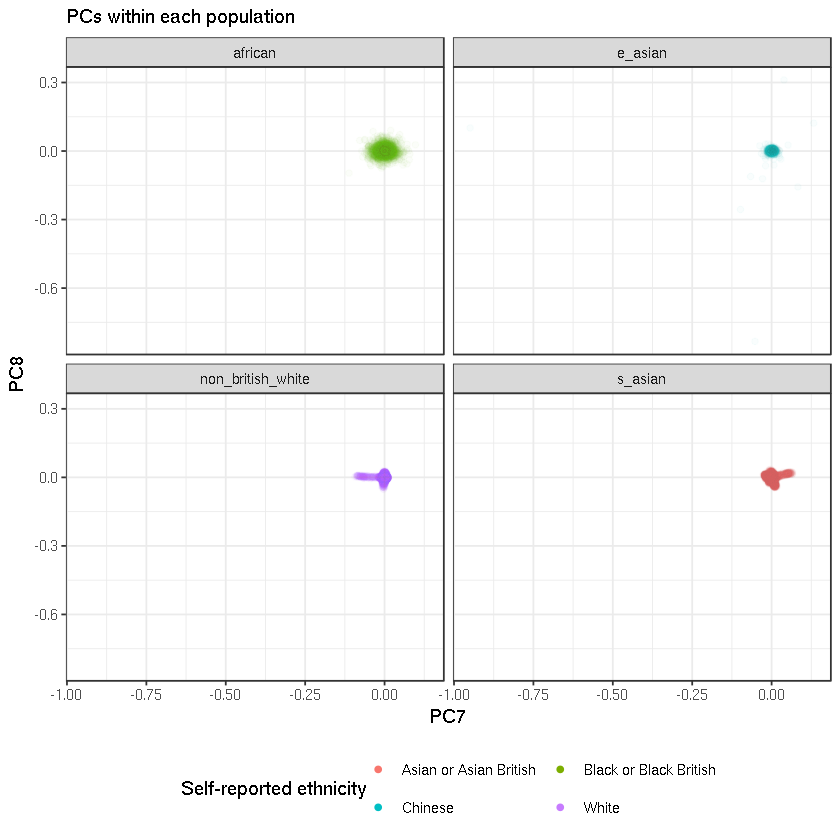

In [57]:
eigenvec_refined_df %>% plot_eigenvec('PC7', 'PC8')


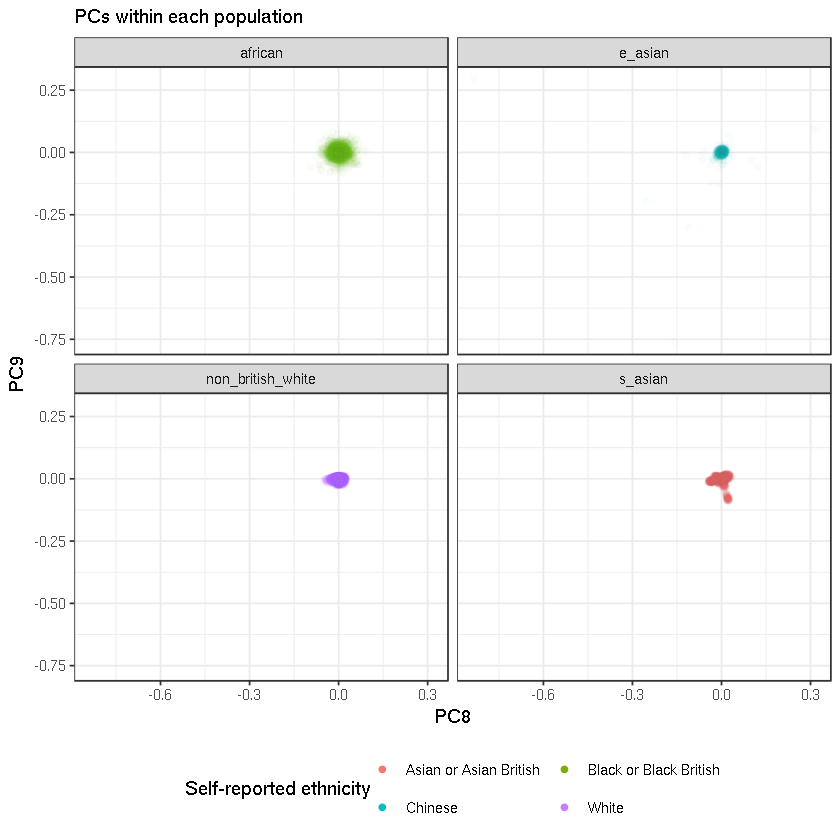

In [58]:
eigenvec_refined_df %>% plot_eigenvec('PC8', 'PC9')


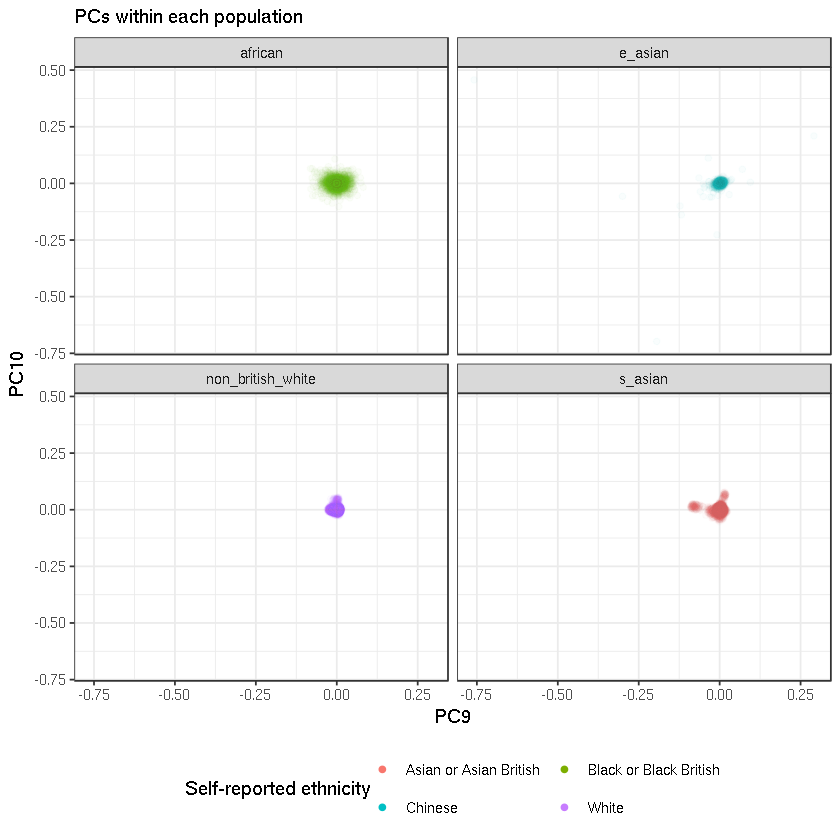

In [59]:
eigenvec_refined_df %>% plot_eigenvec('PC9', 'PC10')


### visualize the global PCs

In [48]:
plot_global_PCs <- function(df, x_axis, y_axis){    
    df %>% drop_na(f21000) %>% filter(pass_filter, f21000 != -3, f21000 != -1) %>%
    replace_na(list(population='others')) %>%
    rename(plot_x = x_axis, plot_y = y_axis) %>%    
    ggplot(aes(x = plot_x, y = plot_y, color=as.factor(f21000_top_label))) +
    geom_point(alpha=.025) +
    theme_bw() + theme(legend.position="bottom") +
    guides(colour = guide_legend(override.aes = list(alpha = 1), nrow=2, byrow=TRUE)) +
    labs(x = x_axis, y = y_axis, title='Global PCs', color='Self-reported ethnicity') + 
    facet_wrap( ~ population, ncol=3) 
}

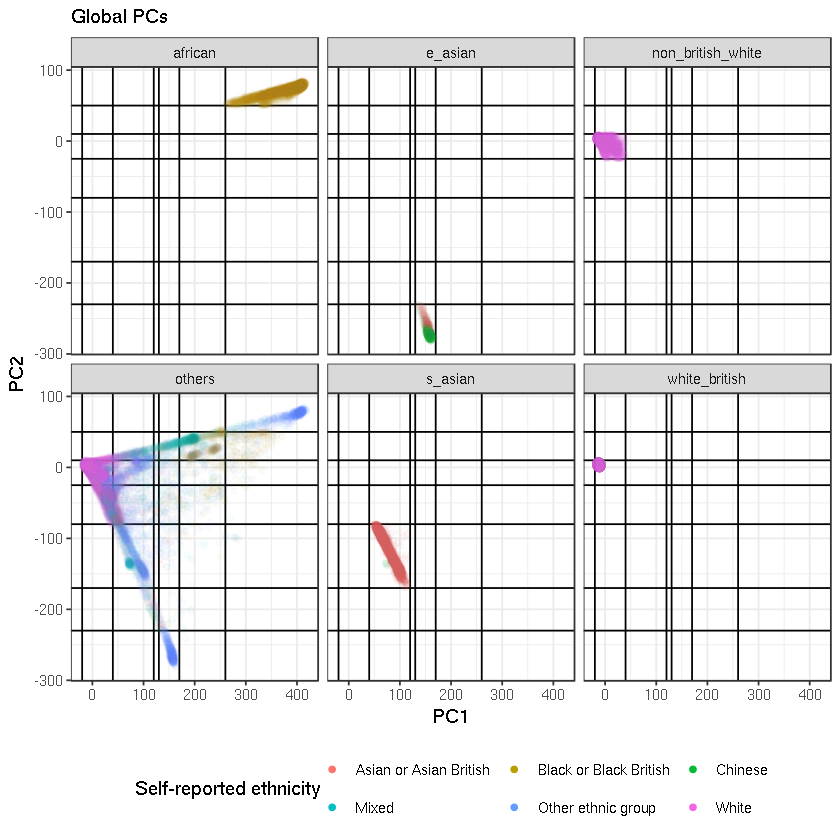

In [49]:
master_sqc_pop_df %>% drop_na(f21000) %>% filter(pass_filter, f21000 != -3, f21000 != -1) %>%
replace_na(list(population='others')) %>%
ggplot(aes(x = PC1, y = PC2, color=as.factor(f21000_top_label))) %>%
pca_plot_lines() +
geom_point(alpha=.025) +
theme_bw() + theme(legend.position="bottom") +
guides(colour = guide_legend(override.aes = list(alpha = 1), nrow=2, byrow=TRUE)) +
labs(title='Global PCs', color='Self-reported ethnicity') + 
facet_wrap( ~ population, ncol=3) 


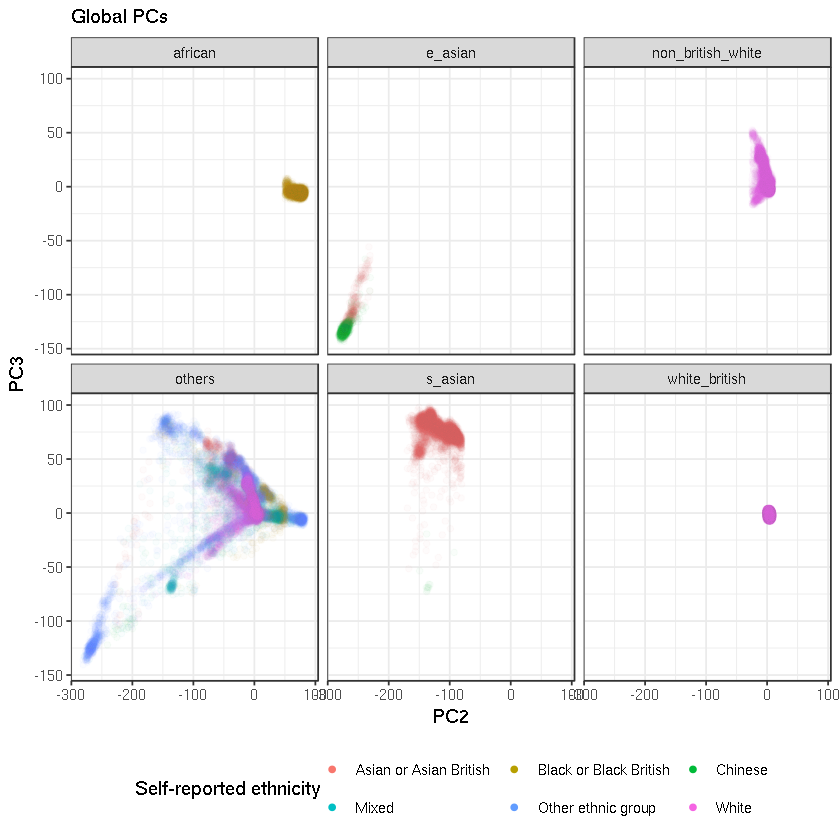

In [50]:
master_sqc_pop_df %>% plot_global_PCs('PC2', 'PC3')

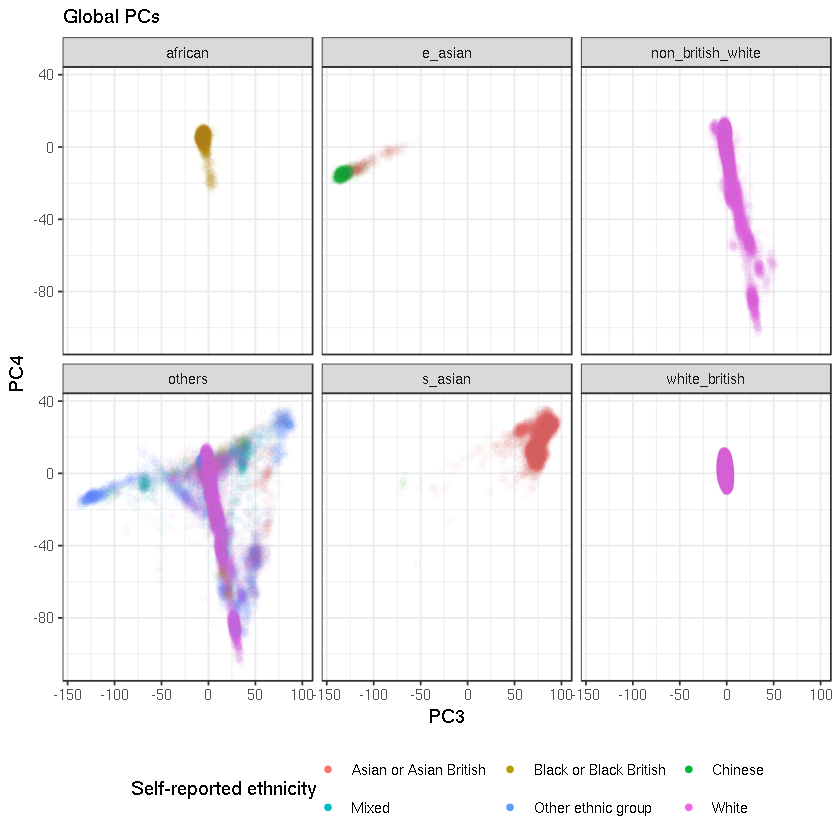

In [51]:
master_sqc_pop_df %>% plot_global_PCs('PC3', 'PC4')

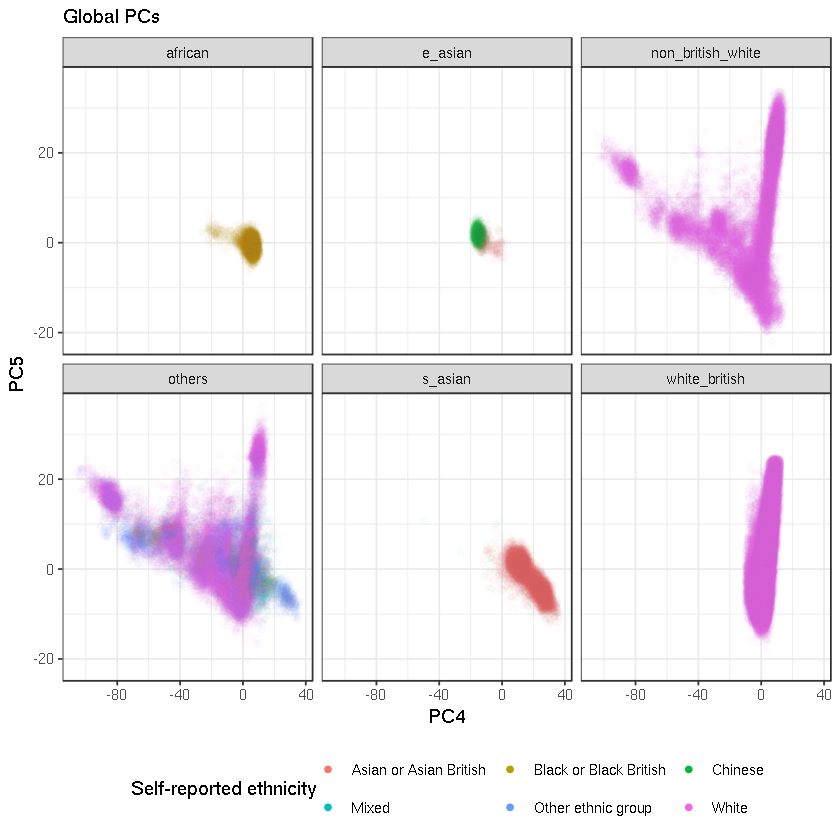

In [52]:
master_sqc_pop_df %>% plot_global_PCs('PC4', 'PC5')

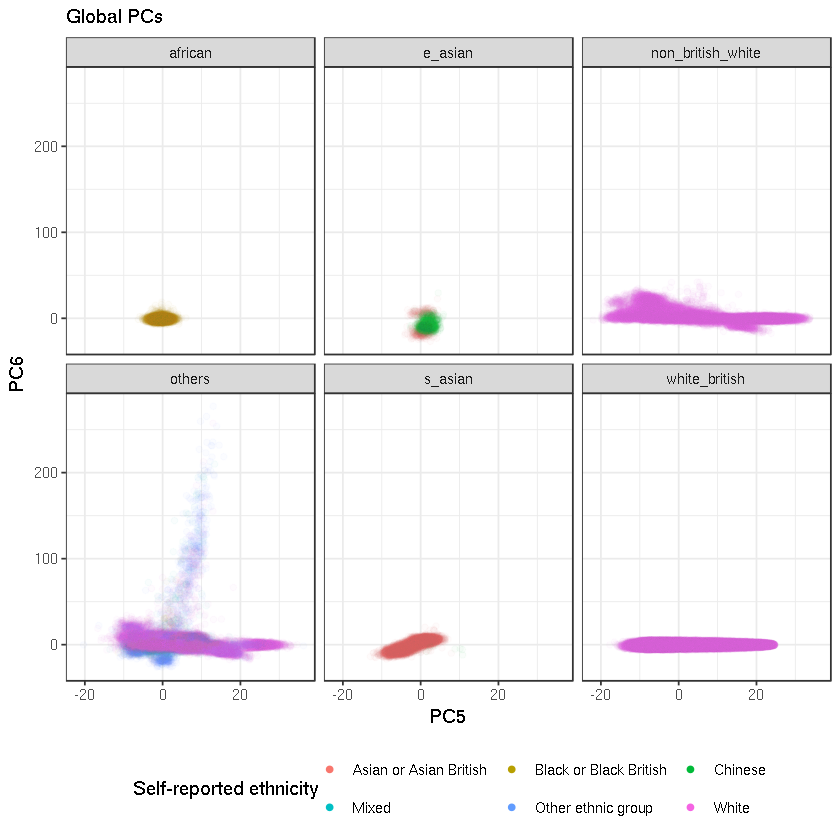

In [53]:
master_sqc_pop_df %>% plot_global_PCs('PC5', 'PC6')

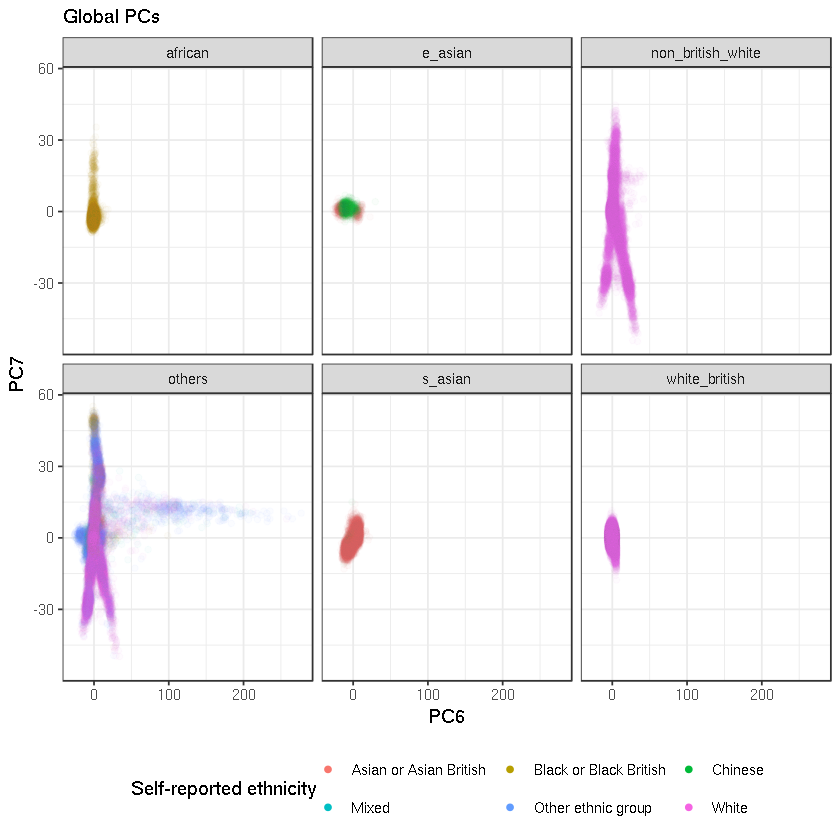

In [54]:
master_sqc_pop_df %>% plot_global_PCs('PC6', 'PC7')

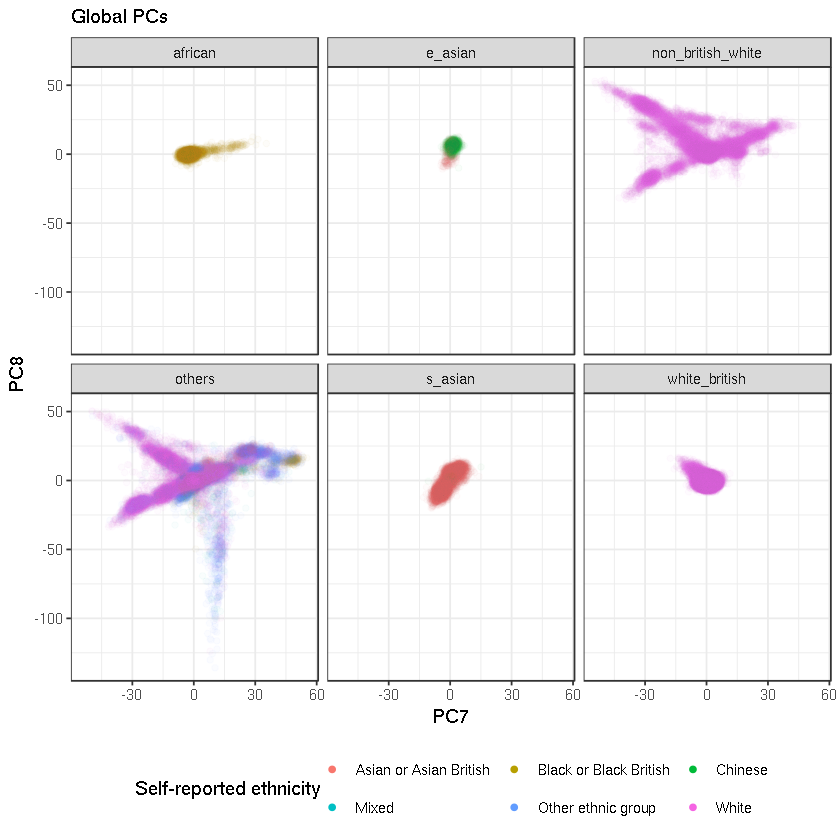

In [55]:
master_sqc_pop_df %>% plot_global_PCs('PC7', 'PC8')

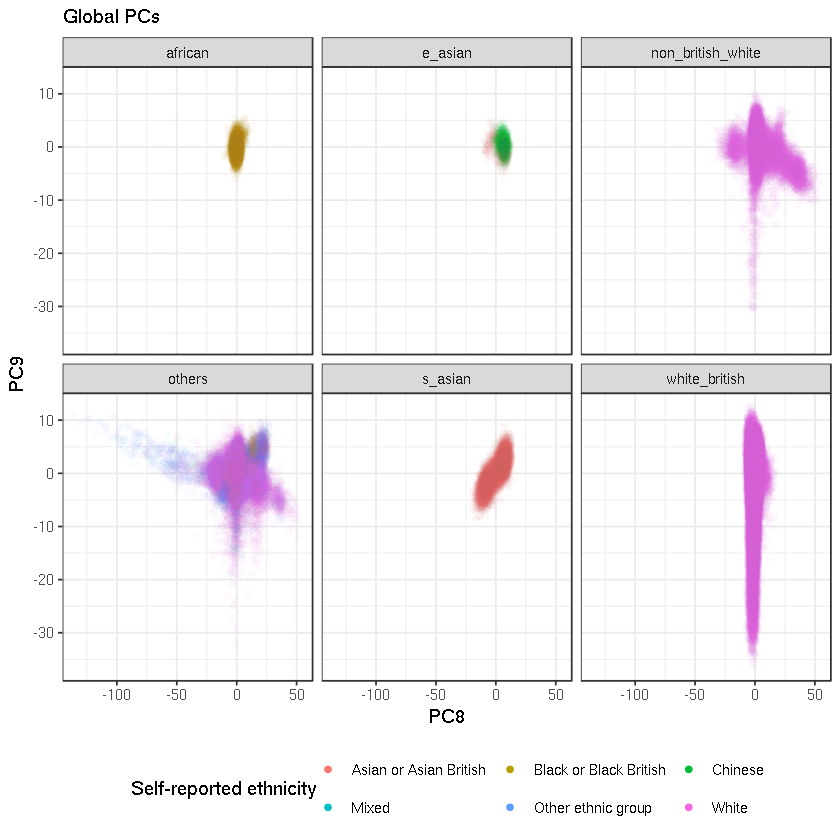

In [56]:
master_sqc_pop_df %>% plot_global_PCs('PC8', 'PC9')

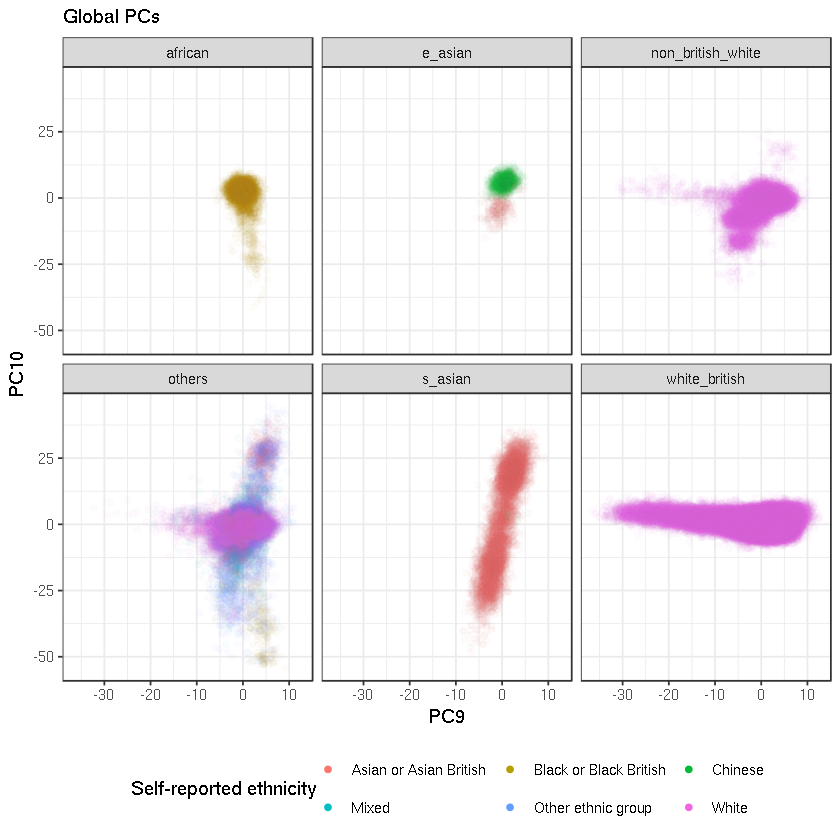

In [57]:
master_sqc_pop_df %>% plot_global_PCs('PC9', 'PC10')